<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Библиотеки, настройки и функции

### Библиотеки

In [1]:
import warnings
import time
import re

from tqdm import notebook

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from catboost import Pool

import torch
from transformers import BertTokenizer, BertModel

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import optuna

### Config

In [52]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

PALETTE = {0: '#008744', 1: '#d62d20'}

BERT_PTM = "nreimers/MiniLM-L6-H384-uncased" # "distilbert-base-multilingual-cased"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


torch.set_grad_enabled(False)

sns.set_theme(style="whitegrid")

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.set_option('display.max_colwidth', 100)

warnings.filterwarnings('ignore')

### Функции

#### Замер времени

In [41]:
def exec_time(start, end):
    '''
    This function calculates the difference between two given datetime objects
    and returns the difference in the format of HH:MM:SS.

    Parameters
    start: datetime object
    end: datetime object
    Returns
    diff_time (str): The difference between the two given datetime objects in
                     the format of HH:MM:SS.
    '''
    diff_time = end - start
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))

    return "Completed for {0:02d}:{1:02d}:{2:02d}".format(h, m, s)

#### Работа с данными

In [42]:
def df_quik_view(df, asc=False, print_time=True):
    '''
    This function provides a quick overview of the input DataFrame by
    returning a summary table containing information such as number of
    unique values, missing values, data type, completeness percentage, and
    unique values of each column in the DataFrame. It also prints general 
    information such as the shape of the table, the number and percentage of
    duplicates in the table, and the memory usage of the table.
    
    Parameters:
    df (pd.DataFrame): a pandas DataFrame to analyze.
    asc (bool): a boolean value indicating whether to sort unique values in
                ascending order. Default is False, which means descending order.
    
    Returns:
    pd.DataFrame: a summary table of the input DataFrame containing the number
                  of unique values, missing values, data type, completeness
                  percentage, and unique values of each column.
    '''
    start = time.time() if print_time else None

    unique_values = []
    for i in df.columns:
        unique_values.append(df[i].sort_values(ascending=asc).unique())

    nans = df.isna().sum()
    table_scan = pd.DataFrame(
        {
            'values_num':    df.count(),
            'nulls_num':     df.isna().sum(),
            'completeness':  100 - (nans / (nans + df.notna().sum()) * 100),
            'uniques_num':   df.nunique(),
            'unique_values': unique_values,
            'dtype':         df.dtypes
        }
    )

    df_shape = df.shape
    duplicates = df.duplicated().sum()
    memory = df.memory_usage(index=False).sum() / 1_000_00
    print('General data analysis:')
    print()
    print('Shape of the table:     ', df_shape)
    print('Duplicates in the table: {}, ({}%)'
          .format(duplicates, round(duplicates / df_shape[0], 4) * 100)
         )
    print('Memory usage:            ' + str(round(memory, 1)) + '+ MB')
    print()

    if print_time:
        end = time.time()
        print('\n')
        print("======================")
        print(exec_time(start, end))
        print("======================")
    
    return table_scan

## Подготовка

In [43]:
data = pd.read_csv("toxic_comments.csv")
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They wer...,0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, Januar...",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relev...",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when your view completely contradicts the coverage in r...",0
159288,159447,You should be ashamed of yourself \n\nThat is a horrible thing you put on my talk page. 128.61....,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for prostitution ring. - Crunch Captain.",0
159290,159449,And it looks like it was actually you who put on the speedy to have the first version deleted no...,0


In [44]:
df_quik_view(data)

General data analysis:

Shape of the table:      (159292, 3)
Duplicates in the table: 0, (0.0%)
Memory usage:            38.2+ MB



Completed for 00:00:01


,values_num,nulls_num,completeness,uniques_num,unique_values,dtype
Unnamed: 0,159292,0,100.0,159292,"[159450, 159449, 159448, 159447, 159446, 159445, 159444, 159443, 159442, 159441, 159440, 159439,...",int64
text,159292,0,100.0,159292,[﻿Sensual Pleasures of the MindItalic text\n\nThere are endless creative ways to provoke and cap...,object
toxic,159292,0,100.0,2,"[1, 0]",int64


In [45]:
data = data[["text", "toxic"]]

In [46]:
data["string_len"] = data["text"].apply(
    lambda x: len(re.sub(" *", "", x)))

In [47]:
data.sort_values(by="string_len").head(10)

,text,toxic,string_len
119018,"""""""",1,3
137400,"== """"""",0,5
136820,~ J.Lo,0,5
52336,"14:53,",0,6
118650,FUCK YOU,1,7
15432,"Howdy!""",0,7
120868,you suck,1,7
109794,{{unbloc,0,8
134053,YOU\n\n CUNT,1,9
150648,"04:59, 22 Au",0,10


In [48]:
data = data.drop(119018, axis=0).reset_index(drop=True)

In [49]:
data[data['text'].str.contains(re.compile(r'[а-яА-ЯёЁ]'), regex=True)]

,text,toxic,string_len
126,"Ahh, Hello Witzeman \n\n203.92.84.161 \nSymbols: ~ | ¡ ¿ † ‡ ↔ ↑ ↓ • ¶ # ½ ⅓ ⅔ ¼ ¾ ⅛ ⅜ ⅝ ⅞ ∞ ...",0,3138
228,http://www.users.bigpond.com/MONTDALE/page8.html Heritage from village Κρανιώνας in macedonian ...,0,138
449,"""\n\n Yobot: incorrect DEFAULTSORT \n\nHi, Yobot an incorrect DEFAULTSORT. It's puzzling as to ...",0,268
996,"It is common knowledge that Karaims (but not Karaite Jews) boast descent from Khazars, but what ...",0,436
1900,"Hi, 牛岩, and welcome to Wikipedia! I hope you like the place and decide to stay. Here are some pa...",0,1205
2645,"I understand your difficulty. I am able to read some other language Wikis, but I can not write a...",0,664
3149,"""\n\nMaybe rather stop campaigning? MY was the one to get the """"Матюки делают з тоби москаля"""" U...",0,286
3790,"""This is the current Smackdown song as of October...... does anyone know the name of it шшє ₣дN ...",0,183
4228,"""\nno seriousy. the only thing i think actually did or said against your precious wikipedia pol...",1,3849
4248,Were those Russian tourists by any chance drinking водка? (Just a guess...),0,64


Target distribustion:

0    0.898394
1    0.101606
Name: toxic, dtype: float64



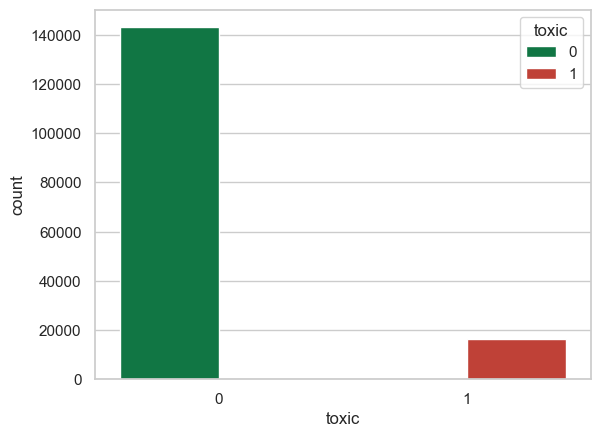

In [50]:
print("Target distribustion:")
print()
print(data["toxic"].value_counts(normalize=True))
print()
sns.countplot(data=data, x="toxic", hue="toxic", palette=PALETTE)
plt.show()

In [53]:
tokenizer = BertTokenizer.from_pretrained(BERT_PTM)
model = BertModel.from_pretrained(BERT_PTM)
model = model.to(DEVICE)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/614 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [18]:
data["text"].apply(len).describe()

count    159291.000000
mean        393.693743
std         590.112873
min           6.000000
25%          95.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: text, dtype: float64

In [29]:
max_length = 256

In [54]:
%%time

encoded_inputs = tokenizer.batch_encode_plus(
    data["text"],
    add_special_tokens=True,
    padding='longest',
    truncation=True,
    max_length=max_length,
    return_tensors='pt')
padded = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

CPU times: total: 1min 56s
Wall time: 5min 29s


In [58]:
%%time

batch_size = 500
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.tensor(padded[batch_size*i:batch_size*(i+1)], dtype=torch.long).to(DEVICE)
    attention_mask_batch = torch.tensor(attention_mask[batch_size*i:batch_size*(i+1)], dtype=torch.long).to(DEVICE)
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

embeddings = np.concatenate(embeddings, axis=0)

embeddings

  0%|          | 0/318 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Обучение

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны